In [16]:
import pandas as pd
import openai
import os
from dotenv import load_dotenv
from typing import Any

## Feedback Loop

In [115]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Data Loading

def get_clean_df(race_stats_csv) -> pd.DataFrame:
    df = (
        pd.read_csv(race_stats_csv)
        .drop(columns=['car_num', 'status', 'winnings']) # maybe come back to status. i don't know what to do with it, but it might be meaningful
    )

    return df


# --- Feature Engineering

def embed_categorical_columns(df: pd.DataFrame, categorical: list[str]) -> pd.DataFrame:
    '''
    A module of functionality for creating embeddings wrapped inside one function call.
    '''

    OpenAIClient = Any # type alias for readability

    def get_openai_client() -> OpenAIClient:
        load_dotenv()
        os.environ.get('OPEN_API_KEY')
        client = openai.OpenAI(
            api_key=os.environ.get('OPEN_API_KEY')
        )

        return client


    def get_embedding(client: OpenAIClient, text: str, model="text-embedding-3-small") -> list[float]:
        return client.embeddings.create(input=text, model=model).data[0].embedding


    def add_pretrained_embeddings(data, columns):
        for column in columns:
            data[f'{column}_emb'] = data[column].apply(lambda x: generate_embeddings(x))
        return data


    def expand_embeddings(data, columns):
        for column in columns:
            emb_df = pd.DataFrame(data[f'{column}_emb'].tolist(), index=data.index, columns=[f"{column}_emb_{i}" for i in range(len(data[f'{column}_emb'][0]))])
            data = pd.concat([data, emb_df], axis=1)
            data.drop(columns=[f'{column}_emb'], inplace=True)
        return data

    df = df.copy()

    client = get_openai_client()

    for column in categorical:
        df[f'{column}_emb'] = df[column].apply(lambda text: get_embedding(client, text))

        # explode the embedding list's into their own columns and add them to the df

        emb_df = pd.DataFrame(
                    df[f'{column}_emb'].tolist(), 
                    index=df.index, 
                    columns=[f"{column}_emb_{i}" for i in range(len(df[f'{column}_emb'][0]))])

        df = (
            pd.concat([df, emb_df], axis=1)
            .drop(columns=[f'{column}_emb'])
        )

    return df


# --- Model Training

def evaluate_model(model, X_test, y_test) -> dict:
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

def train_and_evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    model.fit(X_train, y_train)
    return evaluate_model(model, X_test, y_test)

## Using the Feedback Loop

In [116]:
categorical = ['driver', 'car_name', 'model']
numerical = ['start', 'qual_speed', 'laps', 'led', 'year']

embedded_df_path = 'embedded_df.csv'

if os.path.exists(embedded_df_path):
    df = pd.read_csv(embedded_df_path, index_col=0)
    scaler = StandardScaler()
    df[numerical] = scaler.fit_transform(df[numerical])

else:
    df = (
        get_clean_df('race_stats_2000-2024.csv')
        .pipe(embed_categorical_columns, ['driver', 'car_name', 'model'])
    )

    df.to_csv(embedded_df_path, index=False)

y = df.finish
X = df.drop(columns=['finish'] + categorical)

model = RandomForestRegressor(random_state=3)

evaluation = train_and_evaluate_model(model, X, y)
evaluation

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [79]:
X.iloc[0].to_numpy()

array([ 2.00000000e+00,  2.23372000e+02,  2.00000000e+02, ...,
        2.37530414e-02, -1.02000982e-02,  4.33774287e-04])

<Axes: >

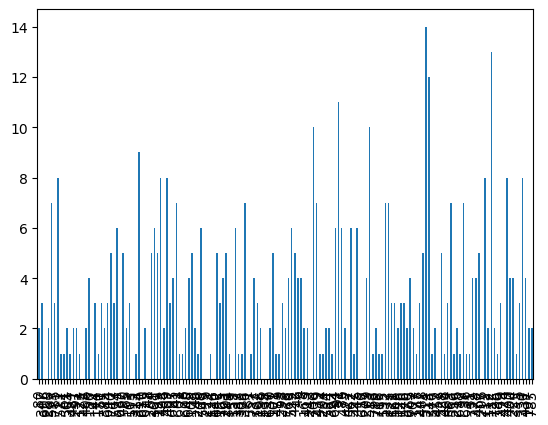

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

lower_bound = 0
upper_bound = len(X)

predictions = model.predict(X_test.iloc[lower_bound:upper_bound])
actual = y_test[lower_bound:upper_bound]

(
    pd.DataFrame(
        {
            'predicted': predictions,
            'actual': actual,
        }
    )
    .assign(predicted=lambda df_: round(df_.predicted))
    .assign(gap=lambda df_: abs(df_.predicted - df_.actual))
)

3.1823899371069184 18.07547169811321


<Axes: title={'center': 'Value Counts: Gap (aka: actual_finish - predicted_finish)'}, ylabel='Frequency'>

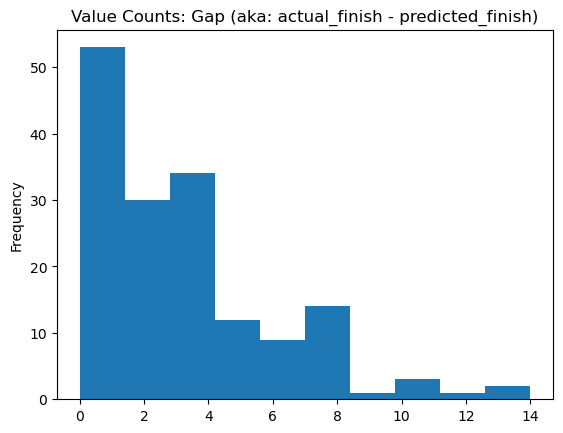

In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test).round()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(mae, mse)

(
    pd.DataFrame(
        {
            'predicted': y_pred,
            'actual': actual,
        }
    )
    .assign(gap=lambda df_: abs(df_.actual - df_.predicted))
    .sort_values(by='gap')
    .gap
    .plot.hist(title='Value Counts: Gap (aka: actual_finish - predicted_finish)')
)


## Next up

- grid search parameter tuning